Questions:
1. How are these algorithms sensitive to the Lipschitz constant?
2. What is a good way to choose L? and correspondingly alpha?

Things to Review:
1. Proximal Function and writing that out

# Least Squares Solver
The least squares optimization problem is as follows:

$$J(f(x)) := \frac{1}{2} \|Ax-b\|_2^2$$

which just uses the L2-norm, square of the Ax=b systems of equations, and minimizes that error.
Gradient of cost function:

$$\nabla{f(x)} = A^T(Ax-b)$$

Generally, b are observations and A is some sort of model transforming our unknown parameter space/variables into the observation predictions.

# Gradient Descent Algorithm
To minimize the cost function, J, just compute the gradient of the cost function and step in that direction. For some $\alpha_{k}$, generally minimizing step size, the iteration is computed in a for loop as follows.

$$x_{k+1} = x_{k} - \alpha_{k}\nabla{f(x)}$$

# ISTA
This is similar to the gradient descent algorithm, but is generally used to solve problems that fall in the class of proximal gradient methods. The new cost function is something as follows:

$$J(f(x)) := \frac{1}{2} \|Ax-b\|_2^2 + r(x)$$

where r(x) can be defined as any proximal, nonsmooth convex function. Examples, include l1, l2, or elastic-net proximal terms. For, those the new cost function is as follows:

$$J(f(x)) := \frac{1}{2} \|Ax-b\|_2^2 + \lambda_1\|x\|_1 + \lambda_2\|x\|_2^2$$ or
$$J(f(x)) := \frac{1}{2} \|Ax-b\|_2^2 + (1-\alpha)\|x\|_1 + \alpha\|x\|_2^2$$ 
with 
$$\alpha = \frac{\lambda_2}{\lambda_2+\lambda_1}$$

The derivation of the iterative algorithm comes from first-order optimality conditions - 0 must be in the subdifferential of the cost function. The new cost function gives rise to a subproblem of solving for $x_{k+1}$ in two segments, one for f(x) and one for r(x). So just set 0 = the subdifferential and then solve for $x_{k+1}$

$$x_{k+1} = Shrink(x_{k} - \alpha_{k}\nabla{f(x)};\lambda\alpha_k)$$

# FISTA
This is ISTA, but with the ideas of Nesterov's Acceleration. It has the same general cost functions as ISTA would with some proximal term. However, with an acceleration/extrapolation term, this algorithm performs with O(1/k^2)

$$x_{k} = Shrink(Y_{k} - \alpha_k\nabla(f(Y));\lambda\alpha_k) \ \text{Proximal Step}$$ 

$$t_{k+1} = \frac{1+\sqrt{1+4t_k^2}}{2} \ \text{Compute Step Size}$$

$$y_{k} = x_{k} + \frac{t_k-1}{t_{k+1}})(x_k - x_{k-1}) \ \text{Extrapolation} $$

## Step Size
All algorithms can use some sort of step size that is arbitrary depending on the problem. A common choice can be using a constant step size = 1/L, where L is the Lipschitz constant for the gradient of the cost function.

1. Least Squares
    $$L = \frac{ \|\mathbf{x}^T \mathbf{x}\|_{op}}{n}$$
2. Logistic
    $$L = \frac{\underset{i}{\max}(\|x_i\|_2^2)}{4n}$$


References:
1. Elastic Net: http://web.stanford.edu/~hastie/TALKS/enet_talk.pdf
2. Code: http://nbviewer.jupyter.org/github/zermelozf/notebooks/blob/master/First%20order%20optimization.ipynb#full
https://github.com/JeanKossaifi/FISTA

3. FISTA: http://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf

In [1]:
import numpy as np
from numpy.linalg import norm
from math import sqrt
import scipy.optimize
from sklearn.base import BaseEstimator
from hashlib import sha1

%matplotlib inline
import matplotlib.pylab as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Define Cost Functions and Gradients

In [21]:
'''
A = matrix of features n_samples X n_features
x = data = n_features X 1
b = observations n_samples X 1
'''
# def least_squares(x, features, labels):
#     """Evaluates the least square function."""
#     n_samples = features.shape[0]
#     x = x.reshape(1, n_features)
#     loss_array = 1/2*(features.dot(x.T) - labels) ** 2
#     return np.sum(loss_array, axis=0)

# def least_squares_grad(x, features, labels):
#     """Evaluates the gradient of the least square function."""
#     n_samples = features.shape[0]
#     x = x.reshape(1, n_features)  # Added for scipy.optimize compatibility
#     grad_array = (features.dot(x.T) - labels) * features
#     return np.sum(grad_array, axis=0) / n_samples

def least_squares(A, x, b):
    """Evaluates the least square function."""
    n_samples, n_features = A.shape
    x = x.reshape(n_features, 1)
    loss_array = 1/2*(A.dot(x) - b) ** 2
    return np.sum(loss_array, axis=0)

def least_squares_grad(A, x, b):
    """Evaluates the gradient of the least square function."""
    n_samples, n_features = A.shape
    x = x.reshape(n_features, 1)  # Added for scipy.optimize compatibility
    grad_array = (A.dot(x) - b) * A
    return (np.sum(grad_array, axis=0) / n_samples).reshape(n_features, 1)

## Define Proximal Operators

In [22]:
# input: x = xk - step*grad
# x_abs > step*lambda_ = shrinkage operator
def prox_l1(x, step, lambda_):
    """ Proximal operator of the l1 norm."""
    x_abs = np.abs(x) # get the absolute value
    shrink_op = step*lambda_ # alpha_k * lambda_
    return np.sign(x) * (x_abs - shrink_op) * (x_abs > shrink_op)

def prox_l2(x, lambda_):
    """ Proximal operator of the l2 norm."""
    return x / (1 + lambda_ / norm(x, 2))

def prox_enet(x, step, l_l1, l_l2, gamma=0.5):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    shrink_op = step * l_l1 * (1.-gamma)
    prox_l1 = np.sign(x) * (x_abs - shrink_op) * (x_abs > shrink_op)
    return prox_l1 / (1. + l_l2*gamma)

In [23]:
def inspector(loss_fun, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    it = [0]  # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = loss_fun(xk)
        err = norm(xk - x_real) / norm(x_real)
        objectives.append(obj)
        errors.append(err)
        if verbose == True:
            if it[0] == 0:
                print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
            if it[0] % (n_iter / 5) == 0:
                print ' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)])
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    return inspector_cl

## Define Linear Algorithms
All algorithms follow some sort of Ax = b estimation of x.

### 01: Subgradient Descent

cond = 52.51
features:  (2000, 50)
real weights:  (50, 1)
b:  (2000, 1)
0.0


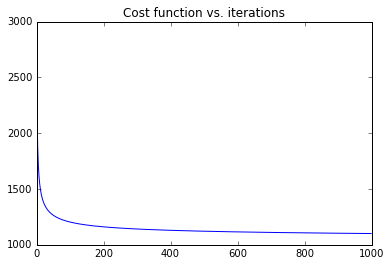

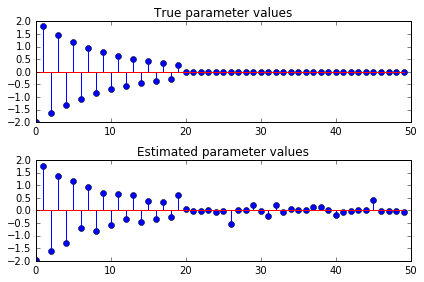

In [24]:
class Subgradient_Descent(BaseEstimator):
    '''
    Class: Subgradient Descent Algorithm
    
    Used to solve unconstrained minimization of possibly nonsmooth f with
    subgradient descent algorithm (generalized gradient descent):
    
    Parameters:
    1. loss: 'hinge', 'least-square', optional loss function
    The default = least-square
    
    2. n_iter: {optional} int, number of iterations
    default = 1000
    
    3. lambda_: {optional} int, regularization parameter, default = 0.0
    
    4. penalty: {optional} 'l11', 'l22', norm for penalty term
    default = None
    The first number is the p penalty. The second number is the q penalty.
    '''
    def __init__(self, loss='least_square', n_iter=1000, lambda_=0.0, penalty=None):
        self.loss = loss
        self.n_iter = n_iter
        self.lambda_ = lambda_
        self.penalty = penalty
    
    def fit(self, A, b, Lipschitz_constant=None, tol=10**(-6), verbose=0):
        ''' Fits the estimator
        We want to solve the problem of the form Ax = b, with some 
        pre-specified loss function
        
        Parameters:
        A: ndarray
        numpy array of shape (n, k)
        where n = number of samples and k = number of features
        
        b: ndarray
        numpy array of shape (n, 1). Observation outcome vector.
        
        tol: int
        the tolerance of the cost function
        
        Lipschitz_constant: {optional}, Default = None
        
        verbose: {optional}, {0, 1}
        '''
        # Determine step size to use based on loss function
        step = least_square_step
        if self.loss == 'hinge':
            step = hinge_step
        
        # determine Lipschitz Constant if none were preset
        if Lipschitz_constant == None:
            Lipschitz_constant = _load_Lipschitz_constant(A)
        
        n_samples, n_features = A.shape
        self.n_samples, self.n_features = n_samples, n_features
        self.tol = tol
        
        # initialize vars to hold estimator and cost
        x_current = np.zeros((n_features,1), dtype=np.float)
        x_next = 1 - 2 * np.random.rand(n_features, 1)
        cost = np.zeros((self.n_iter, 1)) # list to hold obj. fxn at each iter
        
        self.x_init = x_next
        
        # initialize step size
        step_size = step(A)
        
        # set penalty terms
        if self.penalty == 'l11':
            prox = lambda x: prox_l11(x, self.lambda_*Lipschitz_constant)
            
        # set cost and grad
        if self.loss == 'least_square':
            cost_func = lambda x: least_squares(A, x, b)
            grad_func = lambda x: least_squares_grad(A, x, b)
            
        # perform iterative subgradient descent algorithm
        for i in range(self.n_iter):
            ## Perform algorithm
            x_current = x_next # keep a holder on the current x
            x_next = x_current - (step_size/(i+1))*grad_func(x_current) # update x
            
            ## Compute objective function
            penalization = self.lambda_ * norm(x_next, 1)
            cost[i] = cost_func(x_next) + penalization
            
            if cost[i] < tol:
                print "Reached convergence at %i" % i
                break
        
        self.coefs = x_next
        self.cost = cost
    
    def predict(self, A):
        '''
        Parameters
        ----------
        A : ndarray 
            ndarray of size (n_samples, n_features) representing the kernels
        Returns
        -------
        ndarray : the prediction associated to A
        '''
        if self.loss=='hinge':
            return None
        else:
            return np.dot(A, self.coefs)
        
    def score(self, A, b):
        """ Returns the score prediction for the given data
        Parameters
        ----------
        A : ndarray
            matrix of observations and their features
        b : ndarray
            the labels correspondings to A
        Returns
        -------
        The percentage of good classification for A
        """
        return np.sum(np.equal(self.predict(A), b))*100./len(b)
    
def least_squares(A, x, b):
    """Evaluates the least square function."""
    n_samples, n_features = A.shape
    x = x.reshape(n_features, 1)
    loss_array = 0.5 * (A.dot(x) - b) ** 2
    return np.sum(loss_array, axis=0)

def least_square_step(A):
    """
    Returns the generic step size for least-squares cost function
    ----------
    A : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
        
    returns
    -------
    step_size = l_2{(A.T*A) / n}
    """
    n_samples = A.shape[0]
    return norm(A.T.dot(A) / n_samples, 2)

def _load_Lipschitz_constant(A):
    """ 
    Loads the Lipschitz constant and computes it if not already saved. Makes
    the L in (0, 1/||A.T*A||) to ensure convergence
    Parameters
    ----------
    A : 2D-ndarray
        The matrix of witch we want to compute the Lipschitz constant
    Returns
    -------
    float
    Notes
    -----
    Lipshitz constant is just a number < 2/norm(np.dot(K, K.T), 2)
    The constant is stored in a npy hidden file, in the current directory.
    The filename is the sha1 hash of the ndarray
    """
    try:
        mu = np.load('./.%s.npy' % sha1(A).hexdigest())
    except:
        mu = 1/norm(np.dot(A, A.T), 2)
        np.save('./.%s.npy' % sha1(A).hexdigest(), mu)
    return mu
    
## RUN SIMULATION of SGD on dataset
# Generate a fake dataset
n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
params = params.T
diag = np.random.rand(n_features)
A = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

residuals = np.random.randn(n_samples, 1)
b = A.dot(params) + residuals

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())
print 'features: ', A.shape
print 'real weights: ', params.shape
print 'b: ', b.shape

# initialize SGD
sgd = Subgradient_Descent()
sgd.fit(A, b)
print sgd.score(A, b)

# PLOTTING
plt.figure()
plt.title('Cost function vs. iterations')
plt.plot(sgd.cost)

plt.figure()
plt.subplot(211)
plt.title('True parameter values')
plt.stem(params)

plt.subplot(212)
plt.title('Estimated parameter values')
plt.stem(sgd.coefs)
plt.tight_layout()

cond = 1830.28
features:  (2000, 50)
real weights:  (50, 1)
b:  (2000, 1)
0.0


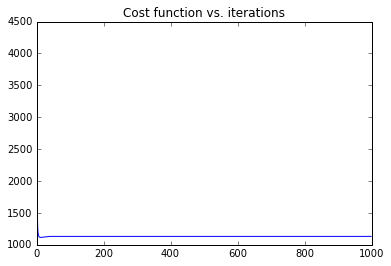

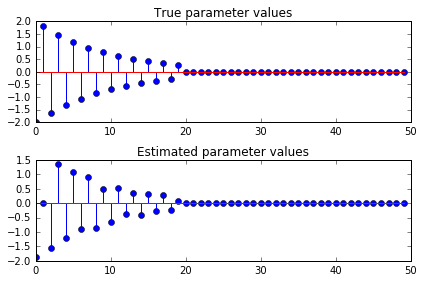

In [25]:
class Ista(BaseEstimator):
    '''
    Class: Iterative Shrinkage and Thresholding Algorithm
    
    Used to solve unconstrained minimization of smooth function f in its 
    proximal form:
    
    Parameters:
    1. lambda_: int, optional regularization parameter, default = 0.5
    
    2. loss: 'squared-hinge', 'least-square', optional loss function
    The default = squared-hinge
    
    3. penalty: 'l11', 'l22', optional norm for penalty term
    default = l11
    The first number is the p penalty. The second number is the q penalty.
    
    4. n_iter: int, optonal number of iterations
    default = 1000
    '''
    def __init__(self, l11=0.3, l22=0.0, loss='least_square', penalty='l11', n_iter=1000):
        self.loss = loss
        self.l11 = l11
        self.l22 = l22
        self.penalty = penalty
        self.n_iter = n_iter
        
    def fit(self, A, b, tol=10**(-6), Lipschitz_constant=None, verbose=0):
        ''' Fits the estimator
        We want to solve the problem of the form Ax = b, with some 
        pre-specified loss function
        
        Parameters:
        A: ndarray
        numpy array of shape (n, k)
        where n = number of samples and k = number of features
        
        b: ndarray
        numpy array of shape (n, 1). Observation outcome vector.
        
        tol: int
        the tolerance of the cost function
        
        Lipschitz_constant: {optional}, Default = None
        
        verbose: {optional}, {0, 1}
        '''
        # Determine step size to use based on loss function
        step = least_square_step
        if self.loss == 'hinge':
            step = hinge_step
        
        # determine Lipschitz Constant if none were preset
        if Lipschitz_constant == None:
            Lipschitz_constant = _load_Lipschitz_constant(A)
        
        n_samples, n_features = A.shape
        self.n_samples, self.n_features = n_samples, n_features
        self.tol = tol
        
        # initialize vars to hold estimator and cost
        x_current = np.zeros((n_features,1), dtype=np.float)
        x_next = 1 - 2 * np.random.rand(n_features, 1)
        cost = np.zeros((self.n_iter, 1)) # list to hold obj. fxn at each iter
        
        self.x_init = x_next
        
        # initialize step size
        step_size = step(A)
        
        # set penalty terms
        if self.penalty == 'l11':
            prox = lambda x: prox_l11(x, step_size, self.l11)
            
        # set cost and grad
        if self.loss == 'least_square':
            cost_func = lambda x: least_squares(A, x, b)
            grad_func = lambda x: least_squares_grad(A, x, b)
            
        # perform iterative subgradient descent algorithm
        for i in range(self.n_iter):
            ## Perform algorithm
            x_current = x_next # keep a holder on the current x
            x_next = prox(x_current - (step_size)*grad_func(x_current)) # update x
            
            ## Compute objective function
            if self.penalty == 'l11':
                penalization = self.l11 * norm(x_next, 1)
            elif self.penalty == 'l22':
                penalization = 0.5 * self.l22 * norm(x_next, 2)
            elif self.penalty == 'enet':
                gamma = l22 / (l11 + l22)
                penalization = (1-gamma) * norm(x_next, 1) + \
                    gamma * norm(x_next, 2)
        
            cost[i] = cost_func(x_next) + penalization
            
            if cost[i] < tol:
                print "Reached convergence at %i" % i
                break
        
        self.coefs = x_next
        self.cost = cost
    
    def predict(self, A):
        '''
        Parameters
        ----------
        A : ndarray 
            ndarray of size (n_samples, n_features) representing the kernels
        Returns
        -------
        ndarray : the prediction associated to A
        '''
        if self.loss=='hinge':
            return None
        else:
            return np.dot(A, self.coefs)
        
    def score(self, A, b):
        """ Returns the score prediction for the given data
        Parameters
        ----------
        A : ndarray
            matrix of observations and their features
        b : ndarray
            the labels correspondings to A
        Returns
        -------
        The percentage of good classification for A
        """
        return np.sum(np.equal(self.predict(A), b))*100./len(b)
    
def least_squares(A, x, b):
    """Evaluates the least square function."""
    n_samples, n_features = A.shape
    x = x.reshape(n_features, 1)
    loss_array = 0.5 * (A.dot(x) - b) ** 2
    return np.sum(loss_array, axis=0)

def least_square_step(A):
    """
    Returns the generic step size for least-squares cost function
    ----------
    A : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
        
    returns
    -------
    step_size = l_2{(A.T*A) / n}
    """
    n_samples = A.shape[0]
    return norm(A.T.dot(A) / n_samples, 2)

def _load_Lipschitz_constant(A):
    """ 
    Loads the Lipschitz constant and computes it if not already saved. Makes
    the L in (0, 1/||A.T*A||) to ensure convergence
    Parameters
    ----------
    A : 2D-ndarray
        The matrix of witch we want to compute the Lipschitz constant
    Returns
    -------
    float
    Notes
    -----
    Lipshitz constant is just a number < 2/norm(np.dot(K, K.T), 2)
    The constant is stored in a npy hidden file, in the current directory.
    The filename is the sha1 hash of the ndarray
    """
    try:
        mu = np.load('./.%s.npy' % sha1(A).hexdigest())
    except:
        mu = 1/norm(np.dot(A, A.T), 2)
        np.save('./.%s.npy' % sha1(A).hexdigest(), mu)
    return mu

# input: x = xk - step*grad
# x_abs > step*lambda_ = shrinkage operator
def prox_l11(x, step, lambda_):
    """ Proximal operator of the l1 norm."""
    x_abs = np.abs(x) # get the absolute value
    shrink_op = step*lambda_ # alpha_k * lambda_
    return np.sign(x) * (x_abs - shrink_op) * (x_abs > shrink_op)

def prox_l22(x, lambda_):
    """ Proximal operator of the l2 norm."""
    return x / (1 + lambda_ / norm(x, 2))

def prox_enet(x, step, l_l1, l_l2, gamma=0.5):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    shrink_op = step * l_l1 * (1.-gamma)
    prox_l1 = np.sign(x) * (x_abs - shrink_op) * (x_abs > shrink_op)
    return prox_l1 / (1. + l_l2*gamma)
    
## RUN SIMULATION of SGD on dataset
# Generate a fake dataset
n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
params = params.T
diag = np.random.rand(n_features)
A = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

residuals = np.random.randn(n_samples, 1)
b = A.dot(params) + residuals

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())
print 'features: ', A.shape
print 'real weights: ', params.shape
print 'b: ', b.shape

# initialize SGD
ista = Ista(l11=0.05)
ista.fit(A, b)
print ista.score(A, b)

# PLOTTING
plt.figure()
plt.title('Cost function vs. iterations')
plt.plot(ista.cost)

plt.figure()
plt.subplot(211)
plt.title('True parameter values')
plt.stem(params)

plt.subplot(212)
plt.title('Estimated parameter values')
plt.stem(ista.coefs)
plt.tight_layout()

cond = 41.69
features:  (2000, 50)
real weights:  (50, 1)
b:  (2000, 1)
0.0


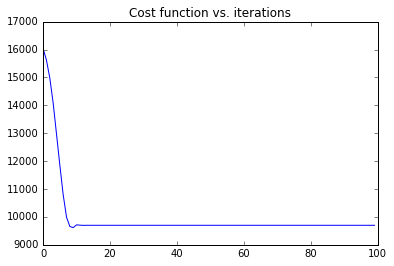

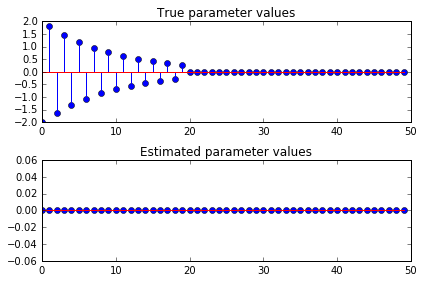

In [26]:
def least_square_stepinit(A):
    """
    Returns the generic step size for least-squares cost function
    ----------
    A : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
        
    returns
    -------
    step_size = l_2{(A.T*A) / n}
    """
    n_samples = A.shape[0]
    return norm(A.T.dot(A) / n_samples, 2)

def hinge_step(b, A, Y):
    """
    Returns the point in witch we apply gradient descent
    parameters
    ----------
    y : np-array
        the labels vector
    K : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
    Z : a linear combination of the last two coefficient vectors
    returns
    -------
    res : np-array of shape n_samples*,_kernels
          a point of the space where we will apply gradient descent
    """
    return np.dot(A.transpose(), np.maximum(1 - np.dot(A, Y), 0))

           
def least_square_step(b, A, Y):
    """
    Returns the point in witch we apply gradient descent
    parameters
    ----------
    b : np-array
        the labels vector
    A : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
    Y : a linear combination of the last two coefficient vectors used
        from the extrapolation step
    
    returns
    -------
    res : np-array of shape n_samples, n_features, to 
    """
    return np.dot(A.T, np.dot(A,Y) - b)

class Fista(BaseEstimator):
    '''
    Class: Fast Iterative Shrinkage and Thresholding Algorithm
    
    Used to solve unconstrained minimization of smooth function f in its 
    proximal form:
    
    Parameters:
    1. lambda_: int, optional regularization parameter, default = 0.5
    
    2. loss: 'squared-hinge', 'least-square', optional loss function
    The default = squared-hinge
    
    3. penalty: 'l11', 'l22', optional norm for penalty term
    default = l11
    The first number is the p penalty. The second number is the q penalty.
    
    4. n_iter: int, optonal number of iterations
    default = 1000
    '''
    def __init__(self, l11=0.3, l22=0.0, loss='least_square', penalty='l11', n_iter=1000):
        self.loss = loss
        self.l11 = l11
        self.l22 = l22
        self.penalty = penalty
        self.n_iter = n_iter
        
    def fit(self, A, b, tol=10**(-6), Lipschitz_constant=None, verbose=0):
        ''' Fits the estimator
        We want to solve the problem of the form Ax = b, with some 
        pre-specified loss function
        
        Parameters:
        A: ndarray
        numpy array of shape (n, k)
        where n = number of samples and k = number of features
        
        b: ndarray
        numpy array of shape (n, 1). Observation outcome vector.
        
        tol: int
        the tolerance of the cost function
        
        Lipschitz_constant: {optional}, Default = None
        
        verbose: {optional}, {0, 1}
        '''
        # Determine step size to use based on loss function
        next_step = least_square_step
        if self.loss == 'hinge':
            next_step = hinge_step
        
        # determine Lipschitz Constant if none were preset
        if Lipschitz_constant == None:
            Lipschitz_constant = _load_Lipschitz_constant(A)
        
        n_samples, n_features = A.shape
        self.n_samples, self.n_features = n_samples, n_features
        self.tol = tol
        
        # initialize vars to hold estimator and cost
        x_current = np.zeros((n_features,1), dtype=np.float)
        x_next = 1 - 2 * np.random.rand(n_features, 1)
        Y = np.copy(x_next)
        cost = np.zeros((self.n_iter, 1)) # list to hold obj. fxn at each iter
        
        self.x_init = x_next
        
        # initialize step size
        tau_next = 1.
        
        # set penalty terms
        if self.penalty == 'l11':
            prox = lambda x: prox_l11(x, tau_next, self.l11)
            
        # set cost and grad
        if self.loss == 'least_square':
            cost_func = lambda x: least_squares(A, x, b)
            grad_func = lambda x: least_squares_grad(A, x, b)
            
        step_size = least_square_stepinit(A)
        
        # perform iterative subgradient descent algorithm
        for i in range(self.n_iter):
            ## Perform algorithm
            x_current = x_next # keep a holder on the current x
            x_next = prox(Y - Lipschitz_constant*step_size/(i+1)*grad_func(x_current))
            
            ## Compute Step Size
            tau_current = tau_next
            tau_next = (1 + sqrt(1 + 4*tau_current**2))/2
            step = (tau_current - 1) / tau_next
            
            ## Perform Extrapolation 
            Y = x_next + step * (x_next - x_current)
            
            ## Compute objective function
            if self.penalty == 'l11':
                penalization = self.l11 * norm(x_next, 1)
            elif self.penalty == 'l22':
                penalization = 0.5 * self.l22 * norm(x_next, 2)
            elif self.penalty == 'enet':
                gamma = l22 / (l11 + l22)
                penalization = (1-gamma) * norm(x_next, 1) + \
                    gamma * norm(x_next, 2)
        
            cost[i] = cost_func(x_next) + penalization
            
            if cost[i] < tol:
                print "Reached convergence at %i" % i
                break
        
        self.coefs = x_next
        self.cost = cost
    
    def predict(self, A):
        '''
        Parameters
        ----------
        A : ndarray 
            ndarray of size (n_samples, n_features) representing the kernels
        Returns
        -------
        ndarray : the prediction associated to A
        '''
        if self.loss=='hinge':
            return None
        else:
            return np.dot(A, self.coefs)
        
    def score(self, A, b):
        """ Returns the score prediction for the given data
        Parameters
        ----------
        A : ndarray
            matrix of observations and their features
        b : ndarray
            the labels correspondings to A
        Returns
        -------
        The percentage of good classification for A
        """
        return np.sum(np.equal(self.predict(A), b))*100./len(b)
    
def hinge_step(b, A, Y):
    """
    Returns the point in witch we apply gradient descent
    parameters
    ----------
    y : np-array
        the labels vector
    K : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
    Z : a linear combination of the last two coefficient vectors
    returns
    -------
    res : np-array of shape n_samples*,_kernels
          a point of the space where we will apply gradient descent
    """
    return np.dot(A.transpose(), np.maximum(1 - np.dot(A, Y), 0))

           
def least_square_step(b, A, Y):
    """
    Returns the point in witch we apply gradient descent
    parameters
    ----------
    b : np-array
        the labels vector
    A : 2D np-array
        the concatenation of all the kernels, of shape
        n_samples, n_kernels*n_samples
    Y : a linear combination of the last two coefficient vectors used
        from the extrapolation step
    
    returns
    -------
    res : np-array of shape n_samples, n_features, to 
    """
    return np.dot(A.T, np.dot(A,Y) - b)

def _load_Lipschitz_constant(A):
    """ 
    Loads the Lipschitz constant and computes it if not already saved. Makes
    the L in (0, 1/||A.T*A||) to ensure convergence
    Parameters
    ----------
    A : 2D-ndarray
        The matrix of witch we want to compute the Lipschitz constant
    Returns
    -------
    float
    Notes
    -----
    Lipshitz constant is just a number < 2/norm(np.dot(K, K.T), 2)
    The constant is stored in a npy hidden file, in the current directory.
    The filename is the sha1 hash of the ndarray
    """
    try:
        mu = np.load('./.%s.npy' % sha1(A).hexdigest())
    except:
        mu = 1/norm(np.dot(A, A.T), 2)
#         np.save('./.%s.npy' % sha1(A).hexdigest(), mu)
    return mu

# input: x = xk - step*grad
# x_abs > step*lambda_ = shrinkage operator
def prox_l11(x, step, lambda_):
    """ Proximal operator of the l1 norm."""
    x_abs = np.abs(x) # get the absolute value
    shrink_op = step*lambda_ # alpha_k * lambda_
    return np.sign(x) * (x_abs - shrink_op) * (x_abs > shrink_op)

def prox_l22(x, lambda_):
    """ Proximal operator of the l2 norm."""
    return x / (1 + lambda_ / norm(x, 2))

def prox_enet(x, step, l_l1, l_l2, gamma=0.5):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    shrink_op = step * l_l1 * (1.-gamma)
    prox_l1 = np.sign(x) * (x_abs - shrink_op) * (x_abs > shrink_op)
    return prox_l1 / (1. + l_l2*gamma)
    
## RUN SIMULATION of SGD on dataset
# Generate a fake dataset
n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
params = params.T
diag = np.random.rand(n_features)
A = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

residuals = np.random.randn(n_samples, 1)
b = A.dot(params) + residuals

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())
print 'features: ', A.shape
print 'real weights: ', params.shape
print 'b: ', b.shape

# initialize SGD
fista = Fista(n_iter=100,l11=0.01)
fista.fit(A, b)
print fista.score(A, b)

# PLOTTING
plt.figure()
plt.title('Cost function vs. iterations')
plt.plot(fista.cost)

plt.figure()
plt.subplot(211)
plt.title('True parameter values')
plt.stem(params)

plt.subplot(212)
plt.title('Estimated parameter values')
plt.stem(fista.coefs)
plt.tight_layout()

## Simulations On Non-OO Functions 

Good for comparing what we should be outputting in the class implementation of sgd, ista, fista.

In [27]:
def grad_descent(x_init, grad, n_iter=100, step=1., tol=None, callback=None):
    x = x_init.copy() # initialize x
    
    # perform iterations
    for _ in range(n_iter):
        x -= step * grad(x)
        
        # update metrics in a function
        if callback is not None:
            callback(x)
            
        # if gradient has reached a low point
        if tol != None and grad(x) <= tol:
            break
            
    return x
# Generate a fake dataset
n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
params = params.T
diag = np.random.rand(n_features)
A = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

residuals = np.random.randn(n_samples, 1)
b = A.dot(params) + residuals

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())
print 'features: ', A.shape
print 'real weights: ', params.shape
print 'b: ', b.shape

# Initialize stuff
x_init = 1 - 2 * np.random.rand(n_features, 1)
n_iter = 30
l_l1 = 0.1
l_l2 = 0.1

test = (A.dot(x_init) - b) * A
test = np.sum(test, axis=0)
print test.shape

# f and gradient
f = lambda x: least_squares(A,x, b)
grad_f = lambda x: least_squares_grad(A, x, b)
step = norm(A.T.dot(A) / n_samples, 2)

# g, F and prox.
g = lambda x: l_l1 * np.abs(x).sum()
F = lambda x: f(x) + g(x)
prox_g = lambda x: prox_l1(x, step, l_l1)

print 'prox',prox_g(x_init).shape
print 'grad',grad_f(x_init).shape

print 'x init: ', x_init.shape
print "n_iter: %d" % n_iter
print "step size: %.2f" % step
# Gradient descent
# Gradient descent
grad_gd = lambda x: grad_f(x) + l_l1 * np.sign(x)
print grad_gd(x_init).shape

gd_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_gd = grad_descent(x_init, grad=grad_gd, n_iter=n_iter, step=step, callback=gd_inspector)

cond = 699.24
features:  (2000, 50)
real weights:  (50, 1)
b:  (2000, 1)
(50,)
prox (50, 1)
grad (50, 1)
x init:  (50, 1)
n_iter: 30
step size: 1.12
(50, 1)
   it    |   obj    |   err   
       0 | 2.73e+03 | 6.19e-01
       6 | 1.48e+03 | 4.67e-01
      12 | 1.43e+03 | 4.58e-01
      18 | 1.46e+03 | 4.76e-01
      24 | 1.42e+03 | 4.37e-01


In [28]:
def ista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        x = prox(x - step * grad(x))
        
        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

def fista(x_init, grad, prox, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    
    for _ in range(n_iter):
        x_new = prox(y - step * grad(y))
        t_new = (1. + (1. + 4. * t**2)**.5) / 2
        y = x_new + (t - 1) / t_new * (x_new - x)
        t = t_new
        x = x_new

        # Update metrics after each iteration.
        if callback is not None:
            callback(x)
    return x

# input: xk
# alpha_k * grad
def prox_l1(x, l=1.):
    """ Proximal operator of the l1 norm."""
    x_abs = np.abs(x)
    return np.sign(x) * (x_abs - l) * (x_abs > l)

def prox_l2(x, l=1.):
    """ Proximal operator of the l2 norm."""
    return 1. / (1 + l) * x

def prox_enet(x, l_l1, l_l2, t=1.):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    prox_l1 = np.sign(x) * (x_abs - t * l_l1) * (x_abs > t * l_l1)
    return prox_l1 / (1. + t * l_l2)

In [29]:
# Generate a fake dataset
n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
params = params.T
diag = np.random.rand(n_features)
A = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

residuals = np.random.randn(n_samples, 1)
b = A.dot(params) + residuals

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())
print 'features: ', A.shape
print 'real weights: ', params.shape
print 'b: ', b.shape

# Initialize stuff
x_init = 1 - 2 * np.random.rand(n_features, 1)
n_iter = 30
l_l1 = 0.1
l_l2 = 0.1

test = (A.dot(x_init) - b) * A
test = np.sum(test, axis=0)
print test.shape

# f and gradient
f = lambda x: least_squares(A,x, b)
grad_f = lambda x: least_squares_grad(A, x, b)
step = norm(A.T.dot(A) / n_samples, 2)

# g, F and prox.
g = lambda x: l_l1 * np.abs(x).sum()
F = lambda x: f(x) + g(x)
prox_g = lambda x: prox_l1(x, step*l_l1)

print 'prox',prox_g(x_init).shape
print 'grad',grad_f(x_init).shape

print 'x init: ', x_init.shape
print "n_iter: %d" % n_iter
print "step size: %.2f" % step

gd_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_ista = ista(x_init, grad=grad_f, prox=prox_g, n_iter=n_iter, step=step, callback=gd_inspector)

cond = 37.27
features:  (2000, 50)
real weights:  (50, 1)
b:  (2000, 1)
(50,)
prox (50, 1)
grad (50, 1)
x init:  (50, 1)
n_iter: 30
step size: 1.11
   it    |   obj    |   err   
       0 | 3.50e+03 | 6.88e-01
       6 | 1.44e+03 | 3.57e-01
      12 | 1.41e+03 | 3.51e-01
      18 | 1.41e+03 | 3.50e-01
      24 | 1.41e+03 | 3.50e-01


In [30]:
# Generate a fake dataset
n_samples = 2000
n_features = 50

idx = np.arange(n_features).reshape(1, n_features)
params = 2 * (-1) ** (idx - 1) * .9**idx
params[0, 20:50] = 0
params = params.T
diag = np.random.rand(n_features)
A = np.random.multivariate_normal(np.zeros(n_features), np.diag(diag), n_samples)

residuals = np.random.randn(n_samples, 1)
b = A.dot(params) + residuals

# Show the condition number of the gram matrix
print "cond = %.2f" % (diag.max() / diag.min())
print 'features: ', A.shape
print 'real weights: ', params.shape
print 'b: ', b.shape

# Initialize stuff
x_init = 1 - 2 * np.random.rand(n_features, 1)
n_iter = 30
l_l1 = 0.1
l_l2 = 0.1

test = (A.dot(x_init) - b) * A
test = np.sum(test, axis=0)
print test.shape

# f and gradient
f = lambda x: least_squares(A,x, b)
grad_f = lambda x: least_squares_grad(A, x, b)
step = norm(A.T.dot(A) / n_samples, 2)

# g, F and prox.
g = lambda x: l_l1 * np.abs(x).sum()
F = lambda x: f(x) + g(x)
prox_g = lambda x: prox_l1(x, step*l_l1)

print 'prox',prox_g(x_init).shape
print 'grad',grad_f(x_init).shape

print 'x init: ', x_init.shape
print "n_iter: %d" % n_iter
print "step size: %.2f" % step

gd_inspector = inspector(loss_fun=F, x_real=params, verbose=True)
x_fista = fista(x_init, grad=grad_f, prox=prox_g, n_iter=n_iter, step=step, callback=gd_inspector)

cond = 13.30
features:  (2000, 50)
real weights:  (50, 1)
b:  (2000, 1)
(50,)
prox (50, 1)
grad (50, 1)
x init:  (50, 1)
n_iter: 30
step size: 1.10
   it    |   obj    |   err   
       0 | 2.61e+03 | 5.30e-01
       6 | 1.45e+03 | 3.50e-01
      12 | 1.47e+03 | 3.68e-01
      18 | 1.47e+03 | 3.69e-01
      24 | 1.47e+03 | 3.66e-01


# Discussion
The general algorithm works for subgradient descent, ista and fista, but the class implementation of fista seems to be broken for now.

In general, Fista seeems to converge within < 10 iterations, while ista takes around 10-15 and sgd is unable to fully characterize the solution. 

Of coursethe final convergence is similar as long as lambda_11 is chosen carefully, but the speed is significantly different.